# Clasificación de malezas según su especie (DeepWeeds)

Con el motivo de aplicar algunos de los conceptos presentados anteriormente sobre redes neuronales convolucionales, en esta sección se implementará una red neuronal convolucional para clasificar algunas especies de malezas en sus entornos nativos (es decir, en entornos no controlados). Este es un problema desafiante y requerirá el uso de técnicas avanzadas como transferencia de aprendizaje (*transfer learning*) para obtener un clasificador de alto rendimiento.

Para el entrenamiento de la CNN se usará el conjunto de datos *DeepWeeds*, el cual consta de 17,509 imágenes etiquetadas de ocho especies de malezas nativas de ocho ubicaciones en el norte de Australia.

<figure>
<center>
<img src='https://i.ibb.co/JnZKNCf/image-004.jpg' width="60%"/>
<figcaption><i>DeepWeeds</i>: (a) Chinee apple, (b) Lantana, (c) Parkinsonia, (d) Parthenium, <br> (e) Prickly acacia, (f) Rubber vine, (g) Siam weed, (h) Snake weed and (i) Negatives</figcaption>
</center>
</figure>

En este [*paper*](https://www.nature.com/articles/s41598-018-38343-3.pdf) se puede encontrar más información sobre el propósito de *DeepWeeds*, el procedimiento que se usó para realizar la recolección de imágenes y otros datos de interés.

_**Nota:** este trabajo contiene algunas imágenes tomadas del paper referenciado (como la imagen mostrada anteriormente)._

### Exploración del conjunto de datos

Se importan las librerías necesarias para la generación de gráficos, el procesamiento de los datos y la creación de redes neuronales convolucionales. Adicionalmente, se declaran constantes que se usarán posteriormente.

In [ ]:
# Librerías.
from IPython.display import set_matplotlib_formats
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

import os


# Configuraciones de librerías.
set_matplotlib_formats("svg")
matplotlib.rcParams["axes.facecolor"] = "white"
sns.set(style="darkgrid")

# Constantes.
WORKSPACE_FOLDER_PATH = "/content/drive/MyDrive/Micro-proyecto 4 - RN & CNN/Workspace"
LABELS_DATASET_FILENAME = "Labels.csv"
DATASET_FOLDER_NAME = "Dataset"
OUTPUT_FOLDER_NAME = "Outputs"

RESNET50_INPUT_SHAPE = (224, 224, 3)
TEST_SET_FRACTION = 0.2  # Fracción de todo el conjunto de datos.
STOPPING_PATIENCE = 8  # Epochs
LR_PATIENCE = 4  # Epochs
MODEL_V1_NAME = "model_v1"
INITIAL_LR = 0.0001
BATCH_SIZE = 32
MAX_EPOCHS = 25
VALIDATION_SET_FRACTION = 0.2  # Fracción del conjunto de entrenamiento.

Se carga el conjunto de datos que contiene las etiquetas (clases) pertenecientes a las imágenes. Es de destacar que dicho conjunto de datos **no necesita ningún tipo de preprocesamiento**.

In [ ]:
labels_dataset = pd.read_csv(os.path.join(WORKSPACE_FOLDER_PATH, LABELS_DATASET_FILENAME))

print(f"En el conjunto de datos hay {labels_dataset.shape[0]} imágenes.\n")
labels_dataset.head()

En el conjunto de datos hay 17509 imágenes.



,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


Se muestra la distribución de clases.

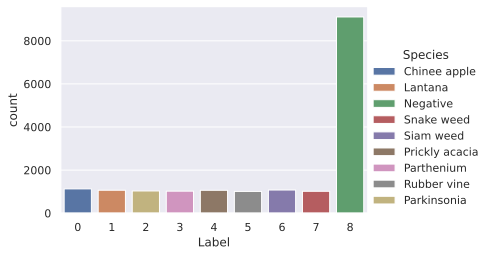

In [ ]:
sns.catplot(x="Label", hue="Species", data=labels_dataset, kind="count", height=3.5, aspect=1.5, dodge=False);

En el histograma anterior se evidencia que la clase *Negative* posee muchas más imágenes que las demás clases, lo que causa un desbalanceo de clases en el conjunto de datos.

Según el *paper* (referenciado anteriormente), las imágenes que no contenían las especies de malezas de interés fueron agrupadas en la clase *Negative*, es decir, esta clase no corresponde a una especie determinada de maleza. Ahora, para evitar entrar en complejidades (en el *paper* se pueden encontrar más detalles) que no son objeto de estudio de este trabajo, las imágenes que posean la clase *Negative* serán retiradas del conjunto de datos.

En el conjunto de datos hay 8403 imágenes actualmente.



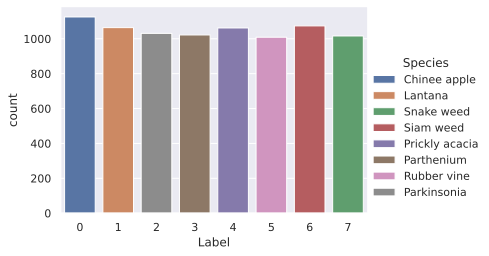

In [ ]:
labels_dataset = labels_dataset[labels_dataset.Species != "Negative"]

print(f"En el conjunto de datos hay {labels_dataset.shape[0]} imágenes actualmente.\n")
sns.catplot(x="Label", hue="Species", data=labels_dataset, kind="count", height=3.5, aspect=1.5, dodge=False);

En la figura anterior se puede evidenciar que todas las clases están prácticamente balanceadas.

### Cargado y preprocesamiento del conjunto de datos

Se cargan y se preprocesan las imágenes para que sean compatibles con la arquitectura *ResNet50* que se usará más adelante.

In [ ]:
def load_dataset(dataset_folder_path, image_filenames):

  dataset = []
    
  for image_filename in tqdm(image_filenames):
        
    # Se carga la imagen.
    image = load_img(
      os.path.join(dataset_folder_path, image_filename),
      target_size=RESNET50_INPUT_SHAPE[:2]
    )
    x = img_to_array(image)

    # Se preprocesa la imagen para que sea compatible con la arquitectura ResNet50.
    x = preprocess_input(x)
        
    dataset.append(x)
    
  return np.array(dataset)


dataset = load_dataset(os.path.join(WORKSPACE_FOLDER_PATH, DATASET_FOLDER_NAME), labels_dataset["Filename"])
labels = labels_dataset["Label"]

100%|██████████| 8403/8403 [39:07<00:00,  3.58it/s]


Se muestran las dimensiones de *dataset* (conjunto de datos [imágenes] de entrada) y de *labels* (vector correspondiente a la variable de salida [especie de maleza]).

In [ ]:
print(f'Dimensiones de "dataset": {dataset.shape}')
print(f'Dimensiones de "labels": {labels.shape}')

Dimensiones de "dataset": (8403, 224, 224, 3)
Dimensiones de "labels": (8403,)


Se divide el conjunto de datos en los conjuntos de entrenamiento (80 % de los datos) y prueba (20 % de los datos).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  dataset, labels, test_size=TEST_SET_FRACTION, random_state=1, stratify=labels
)

# Se libera memoria.
del dataset

print(f'Dimensiones de "X_train": {X_train.shape}')
print(f'Dimensiones de "X_test": {X_test.shape}')

Dimensiones de "X_train": (6722, 224, 224, 3)
Dimensiones de "X_test": (1681, 224, 224, 3)


Con base en lo anterior, se tiene que para las etapas de entrenamiento y prueba se usarán aproximadamente 840 y 210 imágenes de cada especie de maleza, respectivamente.

### Transferencia de aprendizaje y entrenamiento

A continuación, se describen los pasos que componen el procedimiento que se usará para realizar transferencia de aprendizaje:

1. Se carga una CNN preentrenada en el conjunto de datos *ImageNet*, cuya arquitectura es conocida como *ResNet50*. Sin embargo, no se incluirá la capa completamente conectada (*fully-connected layer*) en la parte "superior" de esta CNN, puesto que dicha capa es específica para el conjunto de datos *ImageNet*.
2. Se agrega una capa de *pooling* de tipo *global average* (que será de ayuda para combatir el *overfitting*).
3. Se agrega una capa densa con función de activación sigmoide para realizar la clasificación final.

Así, en este problema se podrá aprovechar todo el "conocimiento" adquirido por una CNN con arquitectura *ResNet50* preentrenada en el conjunto de datos *ImageNet*.

In [ ]:
def create_custom_resnet50(resnet50_input_shape,
                           number_classes,
                           model_name,
                           initial_lr,
                           block_pretrained_layers=False):

  # Se carga una CNN con arquitectura ResNet50 preentrenada en ImageNet.
  resnet50_model_base = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=resnet50_input_shape
  )

  if block_pretrained_layers:

    # Se impide que las capas preentrenadas sean entrenables.
    for layer in resnet50_model_base.layers:
      layer.trainable = False

  # Se agrega una capa de pooling de tipo global average.
  x = resnet50_model_base.output
  x = GlobalAveragePooling2D(name="avg_pool")(x)

  # Se agrega una capa densa con función de activación sigmoide.
  outputs = Dense(number_classes, activation="sigmoid", name="fc8")(x)

  # Se ensambla el modelo a usar.
  model = Model(inputs=resnet50_model_base.input, outputs=outputs, name=model_name)

  model.compile(
    optimizer=Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
  )

  return model


model_v1 = create_custom_resnet50(RESNET50_INPUT_SHAPE, len(labels.unique()), MODEL_V1_NAME, INITIAL_LR)

Se muestra un resumen de la arquitectura de la CNN (versión 1) a usar.

In [ ]:
model_v1.summary()

Model: "model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Se crean *callbacks* para realizar automáticamente los siguientes procesos durante el entrenamiento del modelo: almacenar métricas de entrenamiento, realizar parada anticipada (*early stopping*), almacenar el mejor modelo y reducir la tasa de aprendizaje (*learning rate*) cuando el aprendizaje del modelo se estanque.

In [ ]:
def create_callbacks(output_folder_path, model_name, stopping_patience, lr_patience):

  csv_logger = CSVLogger(os.path.join(output_folder_path, f"training_metrics_{model_name}.csv"))
  early_stopping = EarlyStopping(patience=stopping_patience, verbose=1, restore_best_weights=True)
  model_checkpoint = ModelCheckpoint(os.path.join(output_folder_path, f"best_{model_name}.hdf5"),
    verbose=1,
    save_best_only=True
  )
  reduce_lr = ReduceLROnPlateau(factor=0.5, patience=lr_patience, min_lr=0.000003125)

  return [csv_logger, early_stopping, model_checkpoint, reduce_lr]


callbacks = create_callbacks(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME),
  model_v1.name,
  STOPPING_PATIENCE,
  LR_PATIENCE
)

Se comienza con el proceso de entrenamiento del modelo.

In [ ]:
history_model_v1 = model_v1.fit(
  X_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=MAX_EPOCHS,
  callbacks=callbacks,
  validation_split=VALIDATION_SET_FRACTION,
  shuffle=False,
  steps_per_epoch=X_train.shape[0] // BATCH_SIZE
)

Epoch 1/25
210/210 [==============================] - 734s 3s/step - loss: 0.5436 - sparse_categorical_accuracy: 0.8107 - val_loss: 0.3109 - val_sparse_categorical_accuracy: 0.8937

Epoch 00001: val_loss improved from inf to 0.31093, saving model to /content/drive/MyDrive/Micro-proyecto 4 - RN & CNN/Workspace/Outputs/best_model_v1.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
210/210 [==============================] - 559s 3s/step - loss: 0.0294 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1946 - val_sparse_categorical_accuracy: 0.9383

Epoch 00002: val_loss improved from 0.31093 to 0.19461, saving model to /content/drive/MyDrive/Micro-proyecto 4 - RN & CNN/Workspace/Outputs/best_model_v1.hdf5
Epoch 3/25
210/210 [==============================] - 543s 3s/step - loss: 0.0026 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1864 - val_sparse_categorical_accuracy: 0.9375

Epoch 00003: val_loss improved from 0.19461 to 0.18644, saving model to /content/drive/MyDrive/Micro-proyecto 4 - RN & CNN/Workspace/Outputs/best_model_v1.hdf5
Epoch 4/25
210/210 [==============================] - 546s 3s/step - loss: 7.9346e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1901 - val_sparse_categorical_accuracy: 0.9368

Epoch 00004: val_loss did not improve from 0.18644
Epoch 5/25
210/210 [==============================] - 556s 3s/step - loss: 4.80

En los registros de entrenamiento del modelo (versión 1) se evidencia lo siguiente:

1. El modelo obtuvo una precisión en el conjunto de validación muy alta, incluso desde el *epoch* 1. Esto se debe a la transferencia de aprendizaje realizada previamente.
2. La precisión del modelo almacenado ("el mejor modelo") es de 100 % en el conjunto de entrenamiento y de 93.75 % en el conjunto de validación. Estos datos sugieren que el modelo está un poco sobreajustado (debido a su gran cantidad de parámetros), por lo tanto, usar más datos en el proceso de entrenamiento podría mejorar aún más la capacidad de generalización del modelo (aunque de por sí ya es muy buena).
3. El proceso de entrenamiento se detuvo en el *epoch* 11 gracias a la técnica de *early stopping*, y esto ocurrió porque la pérdida del modelo en el conjunto de validación no mejoró desde el *epoch* 3.

A continuación, se grafican las curvas de aprendizaje.

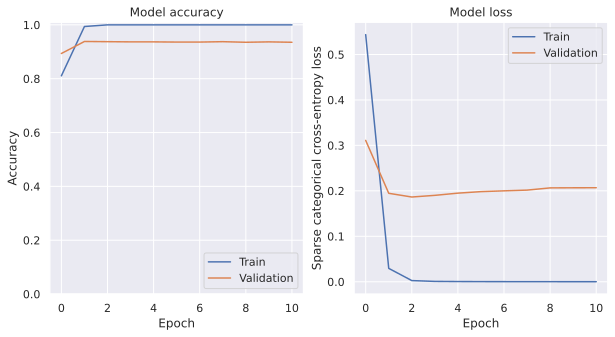

In [ ]:
def plot_learning_curves(training_metrics_csv_path):

  training_metrics = pd.read_csv(training_metrics_csv_path)

  # Se grafican las curvas de aprendizaje para la precisión.
  _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.plot(training_metrics["sparse_categorical_accuracy"])
  ax1.plot(training_metrics["val_sparse_categorical_accuracy"])
  ax1.set(title="Model accuracy", xlabel="Epoch", ylabel="Accuracy")
  ax1.set_ylim(ymin=0)
  ax1.legend(["Train", "Validation"], loc="lower right")

  # Se grafican las curvas de aprendizaje para la pérdida.
  ax2.plot(training_metrics["loss"])
  ax2.plot(training_metrics["val_loss"])
  ax2.set(title="Model loss", xlabel="Epoch", ylabel="Sparse categorical cross-entropy loss")
  ax2.legend(["Train", "Validation"], loc="upper right")


plot_learning_curves(os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"training_metrics_{MODEL_V1_NAME}.csv"))

Se realiza el proceso de inferencia para el conjunto de prueba y se almacenan las predicciones.

In [ ]:
# Se carga el modelo almacenado anteriormente.
model_v1 = load_model(os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"best_{MODEL_V1_NAME}.hdf5"))

# Se realiza el proceso de inferencia.
model_v1_test_predictions = model_v1.predict(X_test)

# Se almacenan las predicciones.
pd.DataFrame({"predictions": np.argmax(model_v1_test_predictions, axis=1)}).to_csv(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"{model_v1.name}_test_predictions.csv"),
  index=False
)

Se muestran las siguientes métricas del modelo: exactitud (*accuracy*), precisión (*precision*), sensibilidad (*recall*) y *F1 score*, adicionalmente, se grafica la matriz de confusión del modelo.

Exactitud del modelo: 93.81320642474718 %
Precisión del modelo: 93.81546040064359 %
Sensibilidad del modelo: 93.81320642474718 %
F1 score del modelo: 93.80448001400883 %



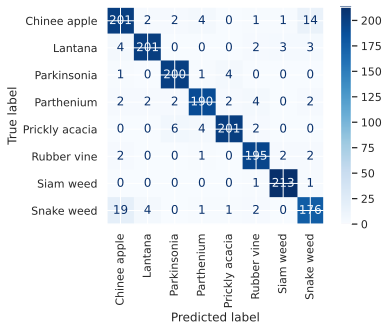

In [ ]:
def show_model_metrics(test_predictions_csv_path, y_test, labels):

  test_predictions = pd.read_csv(test_predictions_csv_path)["predictions"]

  # Se muestran las métricas del modelo. Se usa "weighted" porque las clases no están
  # perfectamente balanceadas, aunque esto no es muy necesario.
  print(f'Exactitud del modelo: {accuracy_score(y_test, test_predictions) * 100} %')
  print(f'Precisión del modelo: {precision_score(y_test, test_predictions, average="weighted") * 100} %')
  print(f'Sensibilidad del modelo: {recall_score(y_test, test_predictions, average="weighted") * 100} %')
  print(f'F1 score del modelo: {f1_score(y_test, test_predictions, average="weighted") * 100} %\n')

  # Se grafica la matriz de confusión del modelo.
  confusion_matrix_ = confusion_matrix(y_test, test_predictions)
  display_ = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, display_labels=labels)
  display_.plot(cmap="Blues", xticks_rotation='vertical', values_format='d')


unique_labels = labels_dataset[["Label", "Species"]].drop_duplicates().sort_values("Label")["Species"]

show_model_metrics(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"{MODEL_V1_NAME}_test_predictions.csv"),
  y_test,
  unique_labels
)

Según la matriz de confusión, las especies que más confunde el modelo son *Snake weed* (a) y *Chinee apple* (b).

<figure>
<center>
<img src='https://i.ibb.co/QDm7zXh/Captura-de-pantalla-2022-01-24-214454.png' width="70%"/>
<figcaption><i>Snake weed y Chinee apple</i></figcaption>
</center>
</figure>

Finalmente, teniendo en cuenta que tanto la exactitud del modelo como su *F1 score* no solo son muy altos, sino que también son casi iguales (~93.8 % ambas métricas), se puede concluir que el modelo construído es de alto rendimiento y es altamente confiable.

<br />

---

***Integrantes:***

1. *Nicolás Capdet Martínez.*

---